In [1]:
!pip install --upgrade open_spiel

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 17.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 7.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for ml-collections: filename=ml_collections-0.1.1-py3-none-any.whl size=94506 sha256=f96e8ad2816d3a2319bc58ff14e6ac4e1356544a0bd4aef11010d9aa60b048ad
  Stored in directory: /root/.cache/pip/wheels/7b/89/c9/a9b87790789e94aadcfc393c283e3ecd5ab916aed0a31be8fe
Successfully built ml-collections


In [2]:
import matplotlib.pyplot as plt

In [3]:
from collections import defaultdict

import pyspiel
import numpy as np
from open_spiel.python import policy
from open_spiel.python.algorithms import expected_game_score, exploitability



In [4]:
def q_function(Q_table, state, action):
    #状態と行動のペアをキーとしてQ値を参照
    return Q_table.get((state.information_state_string(), action), 0)

def v_function(V_table, state):
    #状態をキーとしてV値を参照
    return V_table.get(state.information_state_string(), 0)

def get_action_probabilities(policy, state, legal_actions):
    state_string = state.information_state_string()
    action_probabilities = policy[state_string]
    # 合法的なアクションのみに対する確率を抽出
    filtered_action_probabilities = np.array([action_probabilities[a] for a in legal_actions])
    # 確率を正規化して合計が1になるようにする
    filtered_action_probabilities /= filtered_action_probabilities.sum()
    return filtered_action_probabilities

#ESCHERでの行動選択
def choose_action(state, update_player, current_policy):
    current_player = state.current_player()
    legal_actions = state.legal_actions()
    if current_player != update_player:
        #それ以外のプレイヤーの時は固定分布から行動を選択
        action_probabilities = get_action_probabilities(fixed_policy[-1], state, legal_actions)
    else:
        #更新プレイヤーの時は現在の方策から行動を選択
        action_probabilities = get_action_probabilities(current_policy, state, legal_actions)

    action = np.random.choice(legal_actions, p = action_probabilities)
    return action

#一回のゲームのシミュレーション(trajectory)
def sample_trajectory(game, update_player, t, policies, state, cum_regrets, Q_table, V_table, cum_strategies):
    current_policy = policies[t]
    trajectory = []
    alpha = 0.6
    gamma = 0.85
    if state.is_terminal():
        print(f'プレイヤー{update_player}の報酬：{state.returns()[update_player]}')
        return state.returns()[update_player]
    elif state.is_chance_node():
        # チャンスノードでのアクションを取得し適用
        actions, probs = zip(*state.chance_outcomes())
        action = np.random.choice(actions, p=probs)
        # 選択されたアクションに対応する確率を取得
        action_prob = probs[actions.index(action)]
        state.apply_action(action)
        return action_prob * sample_trajectory(game, update_player, t, policies, state, cum_regrets, Q_table, V_table, cum_strategies)
    else:
        action = choose_action(state, update_player, current_policy)
        state_str = state.information_state_string()
        #Q値の更新
        current_q_value = Q_table.get((state_str, action), 0)
        next_value = sample_trajectory(game, update_player, t, policies, state.child(action), cum_regrets, Q_table, V_table, cum_strategies)
        Q_table[(state_str, action)] = current_q_value + alpha * (next_value + gamma * next_value - current_q_value)
        #V値を更新
        current_v_value = V_table.get(state, 0)
        next_value *= current_policy[state_str][action]
        V_table[state_str] = current_v_value * alpha + next_value * (1 - alpha)
        #V_table[state_str] = last_reward

        legal_actions = state.legal_actions()
        legal_actions_mask = np.array(state.legal_actions_mask())
        state_regret = np.maximum(cum_regrets[state_str], 0)#現在の後悔の値
        if state_regret.sum() > 0:
            #後悔マッチング
            regret_mating_policy = state_regret / state_regret.sum()
            for a in legal_actions:
                policies[t+1][state_str][a] = regret_mating_policy[a]
        else:
            #方策に均等に確率を割り当てる
            policies[t+1][state_str] = legal_actions_mask / legal_actions_mask.sum()

        if state.current_player() == i:
            for a in legal_actions:
                #即時後悔ベクトルrの計算
                immediate_regret = q_function(Q_table, state, a) - v_function(V_table, state)
                #print(f'即時後悔{immediate_regret}')
                #cum_regretの更新
                cum_regrets[state_str][a] += immediate_regret
                #cum_strategiesの更新

        current_policy = policies[-1][state_str]  # 最新のポリシーを取得
        cum_strategies[state_str] += current_policy  # 累積戦略に現在のポリシーを加算

        return next_value
    return 0


class AveragePolicy(policy.Policy):
    def __init__(self, game, player_ids, cum_strategy):
        super().__init__(game, player_ids)
        self.game = game
        self.cum_strategy = cum_strategy

    def action_probabilities(self, state, player_id=None):
        if player_id is None:
            player_id = state.current_player()
        legal_actions = state.legal_actions()
        if not legal_actions:
            return {}
        info_state = state.information_state_string()
        tmp_policy = np.zeros(self.game.num_distinct_actions())
        if info_state in self.cum_strategy and self.cum_strategy[info_state].sum() > 0:
            tmp_policy[legal_actions] = self.cum_strategy[info_state][legal_actions] / self.cum_strategy[info_state][legal_actions].sum()
        else:
            tmp_policy[legal_actions] = 1.0 / len(legal_actions)
        return {action: tmp_policy[action] for action in legal_actions}


0回目
プレイヤー0の報酬：-1.0
exploitable: 0.45833333333333326
プレイヤー1の報酬：2.0
exploitable: 0.45833333333333326
1回目
プレイヤー0の報酬：-2.0
exploitable: 0.45833333333333326
プレイヤー1の報酬：2.0
exploitable: 0.45833333333333326
2回目
プレイヤー0の報酬：1.0
exploitable: 0.41666666666666663
プレイヤー1の報酬：1.0
exploitable: 0.41666666666666663
3回目
プレイヤー0の報酬：-1.0
exploitable: 0.41666666666666663
プレイヤー1の報酬：2.0
exploitable: 0.33333333333333326
4回目
プレイヤー0の報酬：2.0
exploitable: 0.33333333333333326
プレイヤー1の報酬：1.0
exploitable: 0.3472222222222222
5回目
プレイヤー0の報酬：-2.0
exploitable: 0.3194444444444444
プレイヤー1の報酬：-1.0
exploitable: 0.3194444444444444
6回目
プレイヤー0の報酬：1.0
exploitable: 0.3157983180141311
プレイヤー1の報酬：1.0
exploitable: 0.31507781548518166
7回目
プレイヤー0の報酬：-1.0
exploitable: 0.3120830120914876
プレイヤー1の報酬：2.0
exploitable: 0.31081704619386086
8回目
プレイヤー0の報酬：2.0
exploitable: 0.3108170461938608
プレイヤー1の報酬：-1.0
exploitable: 0.31677685049570653
9回目
プレイヤー0の報酬：-2.0
exploitable: 0.3159891383816276
プレイヤー1の報酬：-2.0
exploitable: 0.3229335828260721
10回目
プレイヤー0の報酬：2.0


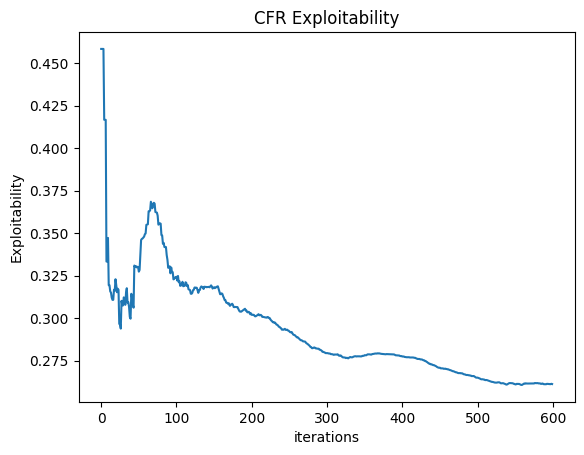

In [6]:
game = pyspiel.load_game('kuhn_poker')
n_actions = game.num_distinct_actions()
cum_regrets = defaultdict(lambda: np.zeros(n_actions))
cum_strategies = defaultdict(lambda: np.zeros(n_actions))
policies = []
policies.append(defaultdict(lambda: np.ones(n_actions) / n_actions))
Q_table = {}
V_table = {}
fixed_policy = []
fixed_policy.append(defaultdict(lambda: np.ones(n_actions) / n_actions))#全ての行動が均等になる。改善の余地あり


T = 300
exploitabilities = []
for t in range(T):
    print(f'{t}回目')
    policies.append(defaultdict(lambda: np.ones(n_actions) / n_actions))#次の戦略の初期化
    for i in range(game.num_players()):
        state = game.new_initial_state()
        sample_trajectory(game, i, t, policies, state, cum_regrets, Q_table, V_table, cum_strategies)

        if (t + 1) % 1 == 0:
            ave_policy = AveragePolicy(game, list(range(game.num_players())), cum_strategies)
            payoffs = expected_game_score.policy_value(
                game.new_initial_state(),[ave_policy, ave_policy])
            exploitable = exploitability.exploitability(game, ave_policy)
            exploitabilities.append(exploitable)
            print(f'exploitable: {exploitable}')

plt.plot(exploitabilities)
plt.title('CFR Exploitability')
plt.xlabel('iterations')
plt.ylabel('Exploitability')
plt.show()